The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue. This challenge is signiﬁcantly easier than all others in this collection. There are no dates, no tables to join, no feature engineering required, and the problem is really straightforward. Therefore, it is a great starting point to get familiar with data science take-home challenges. 

#### We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site). Your project is to: 
 - Predict conversion rate 
 - Come up with recommendations for the product team and the marketing team to improve conversion rate 

In [1]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

### 1. Data Exploration and Data Check

In [2]:
data = pd.read_csv('day1.csv')
data.head(5)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [12]:
# There are no null values 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [13]:
## There might be outliers in age column 
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [32]:
data['country'].value_counts()

US         178092
China       76602
UK          48449
Germany     13055
Name: country, dtype: int64

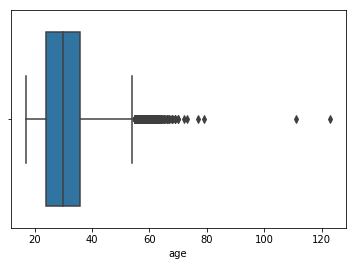

In [14]:
# check age column 
sns.boxplot(data['age'])

In [29]:
# since there are only two outliers and we could remove theme directly at this moment 
data = data[data['age']<100]

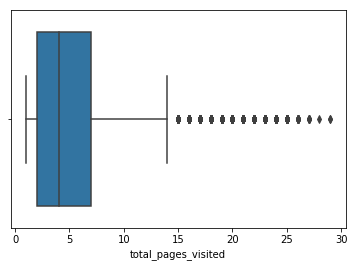

In [30]:
# check total_pages_visited column 
sns.boxplot(data['total_pages_visited'])

In [28]:
## we should pay attention to users whoes total pages visited are higher than 15 
data[data['total_pages_visited']>15].groupby(['country'])['converted'].mean()

country
China      0.366667
Germany    0.969970
UK         0.961610
US         0.953284
Name: converted, dtype: float64

* Most users are from USA, followed by China, UK and Germany. 
* User age are between 17 and 36, which means the user base are relatively young 
* 68.54% users are new users
* The average conversion rate is 3.22%. Why is it an industry standard???
* we should pay attention to users whoes total pages visited are higher than 15 

### 2. Visualization and Deeper analysis 

In [37]:
import altair as alt
alt.renderers.enable('notebook')


RendererRegistry.enable('notebook')

In [34]:
convert_country = data.groupby(['country'])['converted'].mean().reset_index()

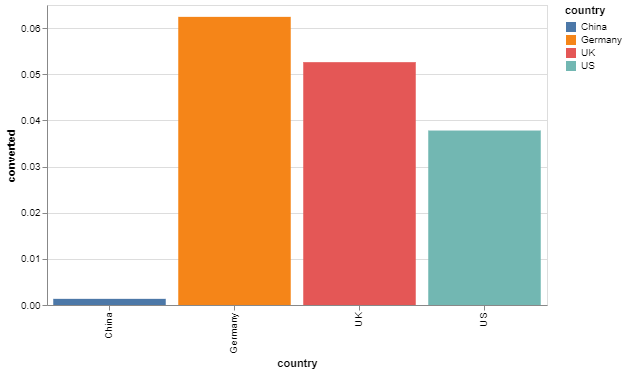

In [40]:
alt.Chart(convert_country).mark_bar().encode(x='country',y='converted', 
                                            color='country:N').properties(width=500, height=300)

In [41]:
convert_user = data.groupby(['new_user'])['converted'].mean().reset_index()

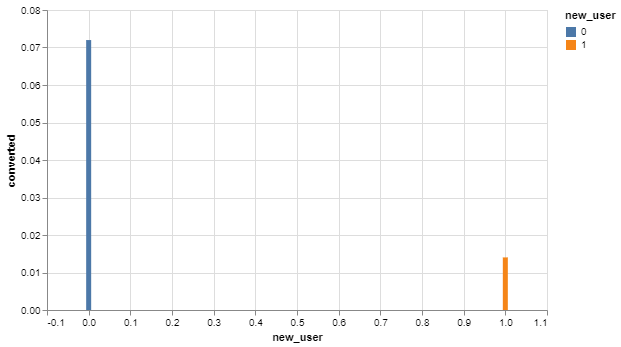

In [42]:
alt.Chart(convert_user).mark_bar().encode(x='new_user',y='converted', 
                                            color='new_user:N').properties(width=500, height=300)

In [43]:
convert_page = data.groupby(['total_pages_visited'])['converted'].mean().reset_index()

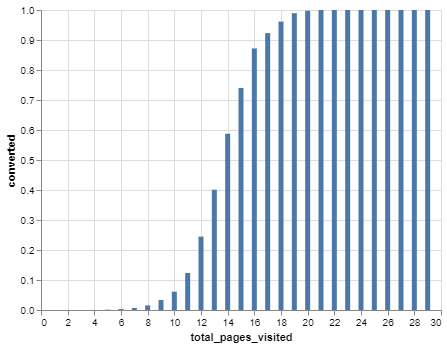

In [45]:
alt.Chart(convert_page).mark_bar().encode(x='total_pages_visited',y='converted')

In [47]:
convert_source =  data.groupby(['source'])['converted'].mean().reset_index()

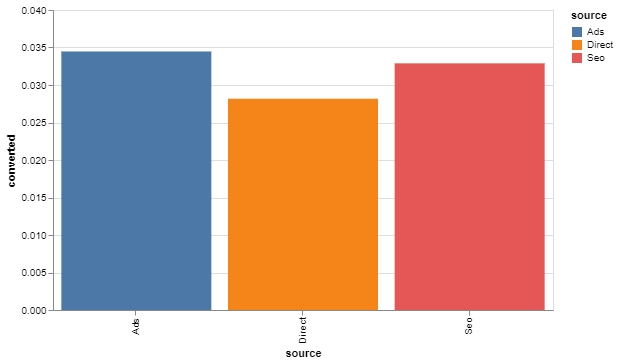

In [49]:
alt.Chart(convert_source).mark_bar().encode(x='source',y='converted',color='source:N').properties(width=500, height=300)

In [58]:
convert_age =  data.groupby(['age'])['converted'].mean().reset_index()

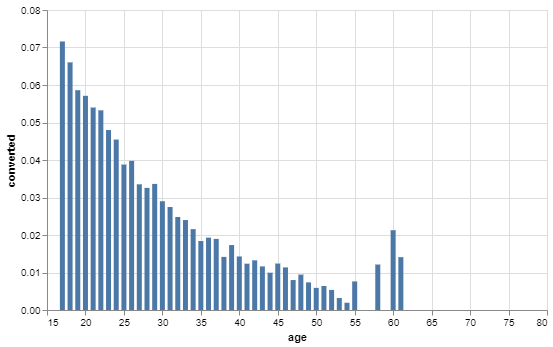

In [61]:
alt.Chart(convert_age).mark_bar().encode(x='age',y='converted').properties(width=500, height=300)

### 3. Predictive Model 

In [64]:
import sklearn
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [51]:
data.head(1)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0


In [52]:
category_features = ['source','country']
category_data = data[category_features]
category_dummy = pd.get_dummies(category_data)
numeric_features = ['age','new_user','total_pages_visited']
numeric_data = data[numeric_features]

In [53]:
X = pd.concat([category_dummy,numeric_data],axis=1 )
y=data['converted']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)

In [56]:
X_train.head(3)

,source_Ads,source_Direct,source_Seo,country_China,country_Germany,country_UK,country_US,age,new_user,total_pages_visited
11214,0,0,1,0,0,0,1,32,1,8
105157,1,0,0,0,0,0,1,36,0,2
110843,1,0,0,0,0,0,1,21,1,6


In [62]:
train = pd.concat([X_train,y_train],axis=1 )

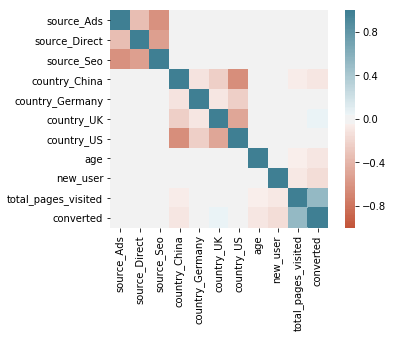

In [63]:
corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)

In [65]:
from sklearn.ensemble import RandomForestClassifier
def draw_roc_curve(y_test, y_proba):
    
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.plot(fpr,tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC curve ')
    plt.xlabel('False positive rate (1-Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')
    plt.grid(True)
    
    return plt.show()

def build_RFC(X_train,y_train,X_test,y_test,X):
    
    clf = RandomForestClassifier()
    clf.fit(X_train,y_train)
    y_pred_train = clf.predict(X_train)
    
    y_pred_test = clf.predict(X_test)
    
    y_proba=clf.predict_proba(X_test)[:,1]
    
    draw_roc_curve(y_test, y_proba)
    

    print('Train accuracy score:',accuracy_score(y_train,y_pred_train))
    print('Test accuracy score:', accuracy_score(y_test,y_pred_test))
    print('Precision score:', precision_score(y_test, y_pred_test))
    print('Recall score:', recall_score(y_test, y_pred_test))
    
    y_pred=clf.predict(X_test)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    class_names=[0,1,2,3]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="coolwarm" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
#     print(clf.coef_)
    
    return pd.crosstab(y_test,pd.Series(y_pred_test),rownames=['ACTUAL'],colnames=['PRED'])

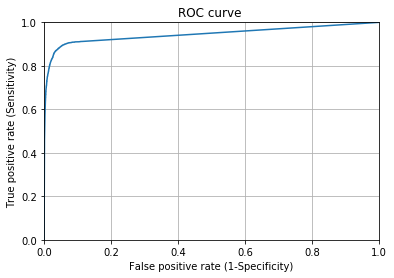

Train accuracy score: 0.9880032722181928
Test accuracy score: 0.98483238456673
Precision score: 0.8044090056285178
Recall score: 0.6868241890268322


PRED,0,1
ACTUAL,,
0,18600,492
1,624,15


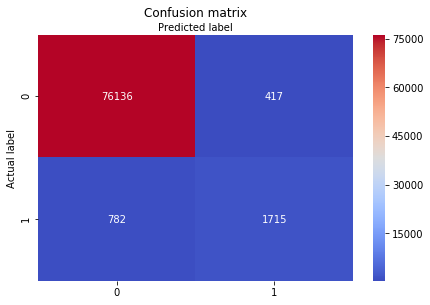

In [66]:
build_RFC(X_train,y_train,X_test,y_test,X)

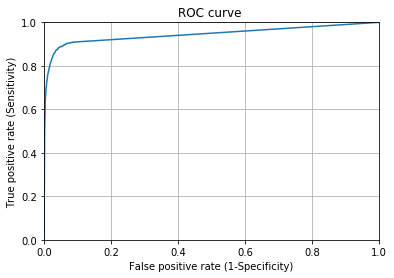

Train accuracy score: 0.9880074889942145
Test accuracy score: 0.9848070841239722
Precision score: 0.8050847457627118
Recall score: 0.6848217861433721


In [77]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred_train = clf.predict(X_train)

y_pred_test = clf.predict(X_test)

y_proba=clf.predict_proba(X_test)[:,1]

draw_roc_curve(y_test, y_proba)

print('Train accuracy score:',accuracy_score(y_train,y_pred_train))
print('Test accuracy score:', accuracy_score(y_test,y_pred_test))
print('Precision score:', precision_score(y_test, y_pred_test))
print('Recall score:', recall_score(y_test, y_pred_test))

In [80]:
importance = clf.feature_importances_

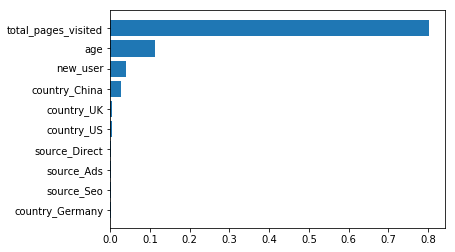

In [82]:
importances = clf.feature_importances_
# Sort importances
sorted_index = np.argsort(importances)
# Create labels
labels = X.columns[sorted_index]
# Clear current plot
plt.clf()
# Create plot
plt.barh(range(X.shape[1]), importances[sorted_index], tick_label=labels)
plt.show()

In [84]:
clf.partial_plot(train, cols=feature, figsize=(8, 15))

AttributeError: 'RandomForestClassifier' object has no attribute 'partial_plot'

{'max_features': 'auto'}


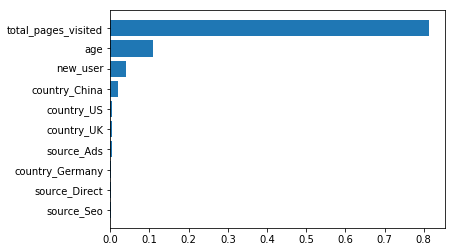

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
def feature_importance(X,y):
    
    clf = RandomForestClassifier()
    clf.fit(X,y)
     # Create the hyperparameter grid
    param_grid = {'max_features': ['auto', 'sqrt', 'log2']}
    # Call GridSearchCV
    grid_search = GridSearchCV(clf, param_grid)
    # Fit the model
    grid_search.fit(X, y)
    # Print the optimal parameters
    print(grid_search.best_params_)
    
    importances = clf.feature_importances_
    # Sort importances
    sorted_index = np.argsort(importances)
    # Create labels
    labels = X.columns[sorted_index]
    # Clear current plot
    plt.clf()
    # Create plot
    plt.barh(range(X.shape[1]), importances[sorted_index], tick_label=labels)
    plt.show()

feature_importance(X_train,y_train)

In [68]:
from sklearn.feature_selection import SelectFromModel

In [69]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [70]:
# sel.get_support()

array([False, False, False, False, False, False, False,  True, False,
        True])

In [76]:
selected_feat= X_train.columns[(sel.get_support())]
# len(selected_feat)
print(selected_feat)

Index(['age', 'total_pages_visited'], dtype='object')


In [85]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

In [89]:
# Here we make the plot
# my_plots = plot_partial_dependence(clf,       
#                                    features=[0, 1, 2], # column numbers of plots we want to show
#                                    X=X,            # raw predictors data.
#                                    feature_names=['total_pages_visited', 'age', 'new_user'], # labels on graphs
#                                    ) # number of values to plot on x axis

#### Limitation of RFC to do feature importance 
* Few of the limitations of Random forest are : Correlated features will be given equal or similar importance, but overall reduced importance compared to the same tree built without correlated counterparts.
* Random Forests and decision trees, in general, give preference to features with high cardinality ( Trees are biased to these type of variables ).
* https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f

https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

https://briangriner.github.io/Partial_Dependence_Plots_presentation-BrianGriner-PrincetonPublicLibrary-4.14.18-updated-4.22.18.html

H2O will work with large numbers of categories. Continuum has made H2O available in Anaconda Python.

https://www.h2o.ai/wp-content/uploads/2018/01/Python-BOOKLET.pdf